# NGO - HELP International : Clustering Countries in order to find out which countries need financial aid.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

### Read and Understanding data

In [3]:
#importing file

cdata=pd.read_csv('country-data.csv')
cdata.head(10)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.440,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.490,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.100,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.400,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.440,76.8,2.13,12200
5,Argentina,14.5,18.9,8.10,16.0,18700,20.900,75.8,2.37,10300
6,Armenia,18.1,20.8,4.40,45.3,6700,7.770,73.3,1.69,3220
7,Australia,4.8,19.8,8.73,20.9,41400,1.160,82.0,1.93,51900
8,Austria,4.3,51.3,11.00,47.8,43200,0.873,80.5,1.44,46900
9,Azerbaijan,39.2,54.3,5.88,20.7,16000,13.800,69.1,1.92,5840


In [4]:
cdata.shape

(167, 10)

In [5]:
cdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [6]:
# to check if we have any null values 
cdata.isna().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

In [7]:
# converting the %age columns to actual values

cdata['exports']=cdata['exports']/cdata['gdpp']*100
cdata['health']=cdata['health']/cdata['gdpp']*100
cdata['imports']=cdata['imports']/cdata['gdpp']*100

In [8]:
cdata.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,1.808318,1.370705,8.119349,1610,9.44,56.2,5.82,553
1,Albania,16.6,0.684597,0.160147,1.188264,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,0.860987,0.093498,0.704036,12900,16.10,76.5,2.89,4460
3,Angola,119.0,1.764873,0.080737,1.215297,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,0.372951,0.049426,0.482787,19100,1.44,76.8,2.13,12200


 ## EDA

### Univariate analysis for numerical columns

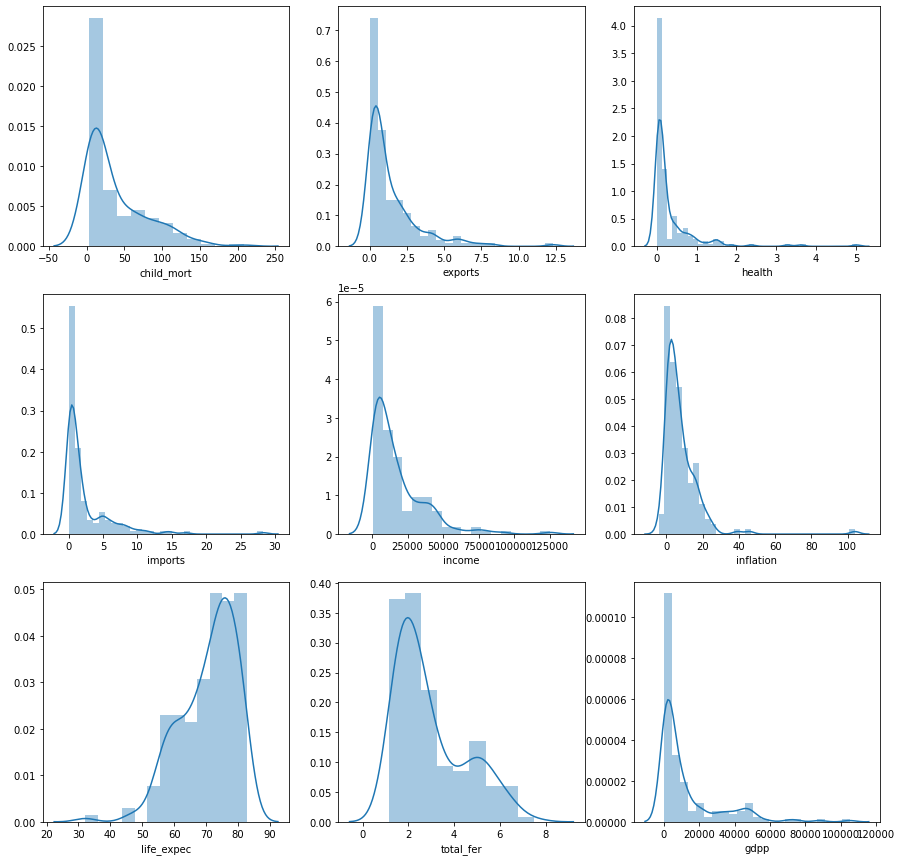

In [9]:
# displot    
col=cdata.columns[1:]
plt.figure(figsize = (15,15))
for i in enumerate(col):
    plt.subplot(3,3, i[0]+1)
    sns.distplot(cdata[i[1]])

### Bi-variate analysis

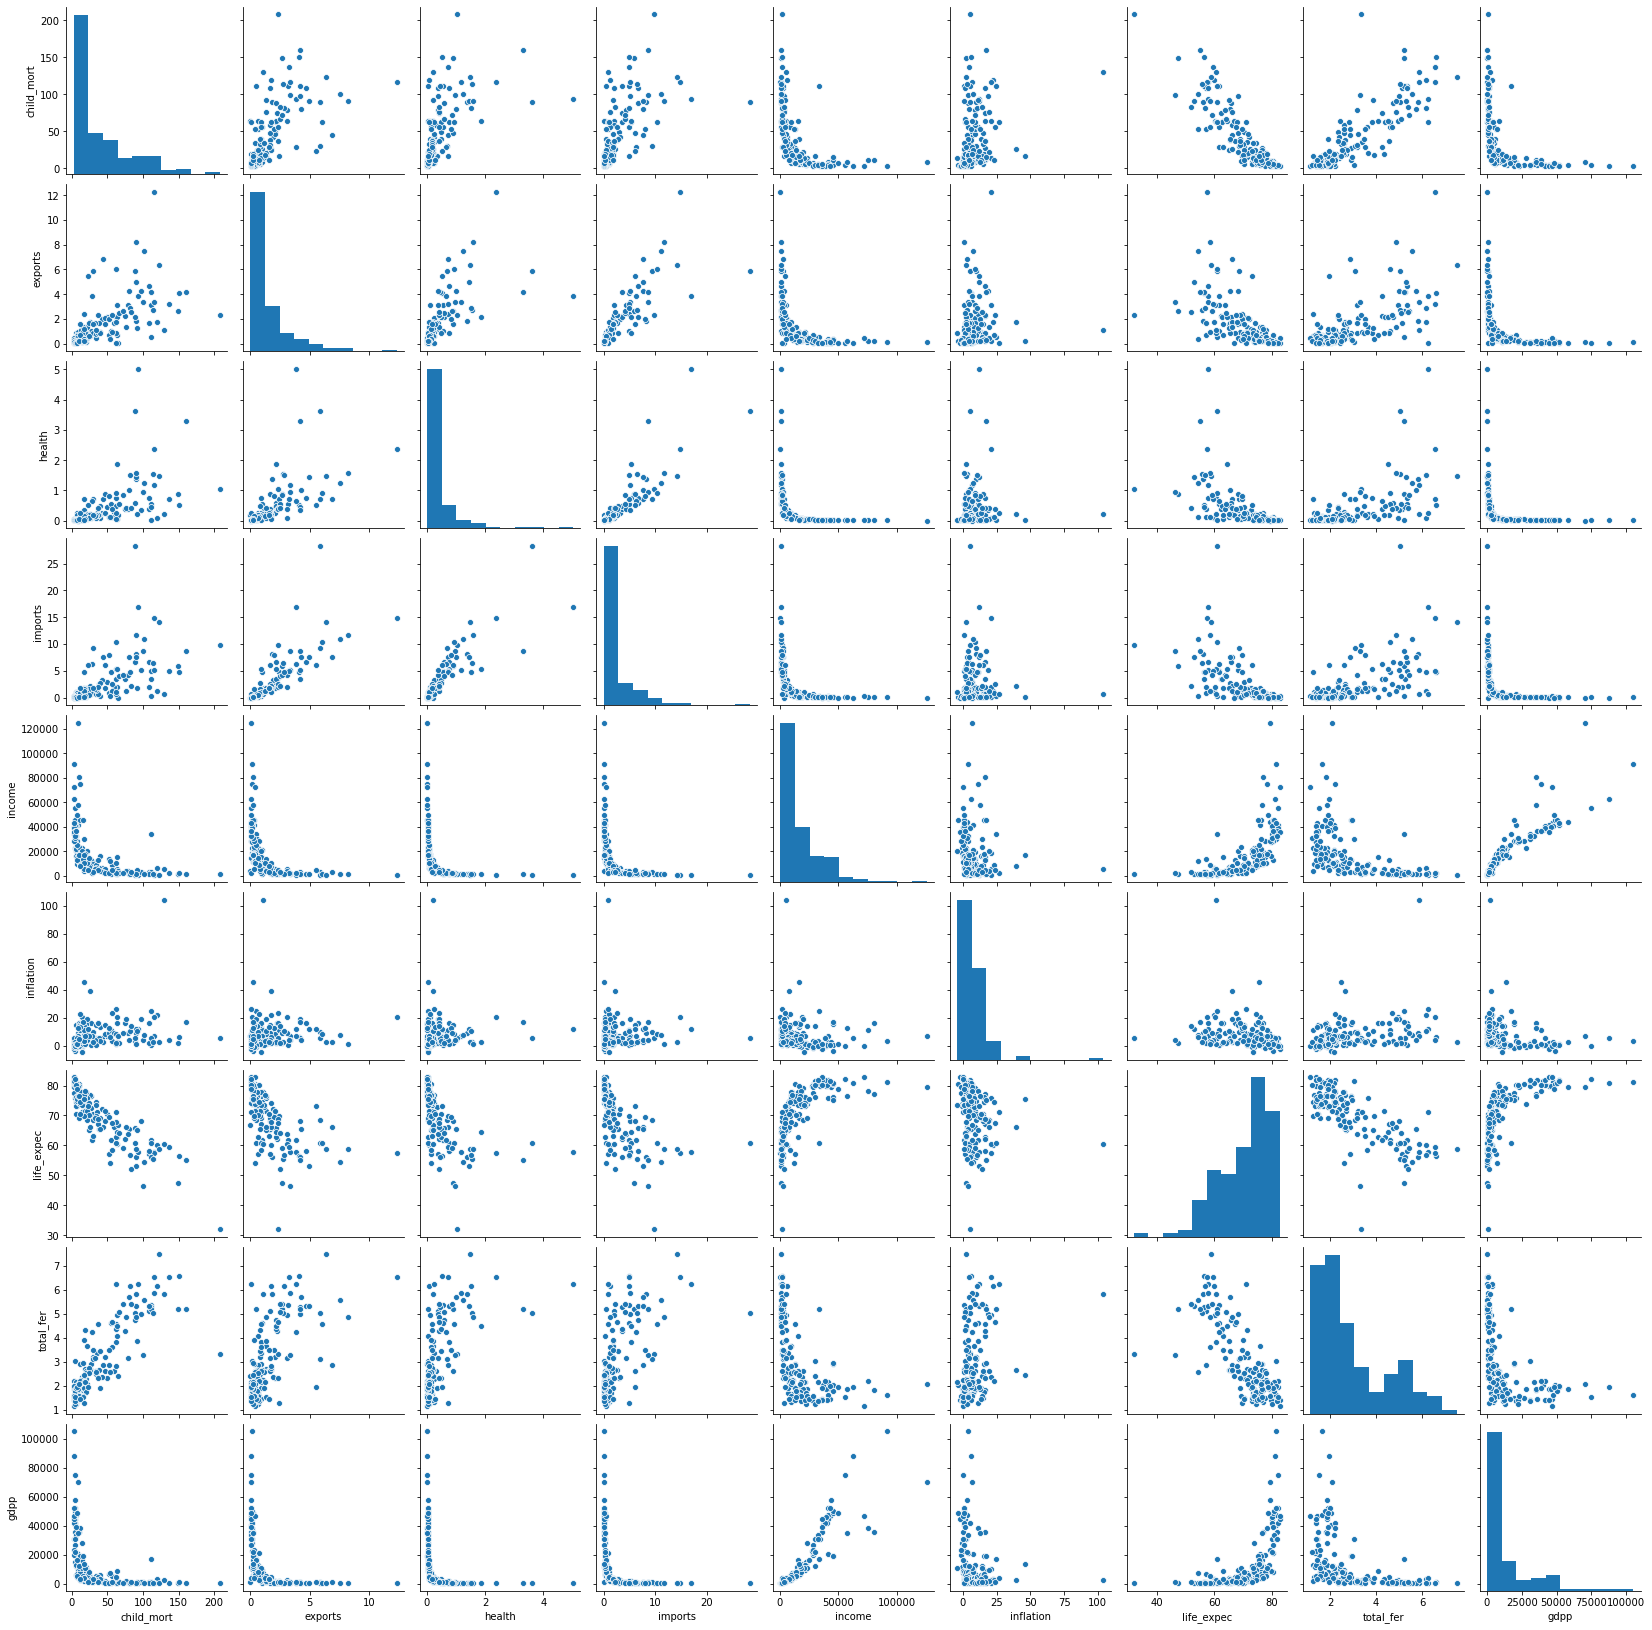

In [10]:
# plotting pair plot for seeing correlation between numerical columns
sns.pairplot(cdata)
plt.show()

In [11]:
# correlation matrix

cor=cdata.corr()
cor

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
child_mort,1.000000,0.632673,0.593627,0.622710,-0.524315,0.288276,-0.886676,0.848478,-0.483032
exports,0.632673,1.000000,0.664660,0.820229,-0.483062,0.107840,-0.621654,0.646602,-0.437098
health,0.593627,0.664660,1.000000,0.872859,-0.390356,0.071109,-0.566274,0.597115,-0.333909
imports,0.622710,0.820229,0.872859,1.000000,-0.445602,0.036771,-0.617441,0.613774,-0.387139
income,-0.524315,-0.483062,-0.390356,-0.445602,1.000000,-0.147756,0.611962,-0.501840,0.895571
inflation,0.288276,0.107840,0.071109,0.036771,-0.147756,1.000000,-0.239705,0.316921,-0.221631
life_expec,-0.886676,-0.621654,-0.566274,-0.617441,0.611962,-0.239705,1.000000,-0.760875,0.600089
total_fer,0.848478,0.646602,0.597115,0.613774,-0.501840,0.316921,-0.760875,1.000000,-0.454910
gdpp,-0.483032,-0.437098,-0.333909,-0.387139,0.895571,-0.221631,0.600089,-0.454910,1.000000


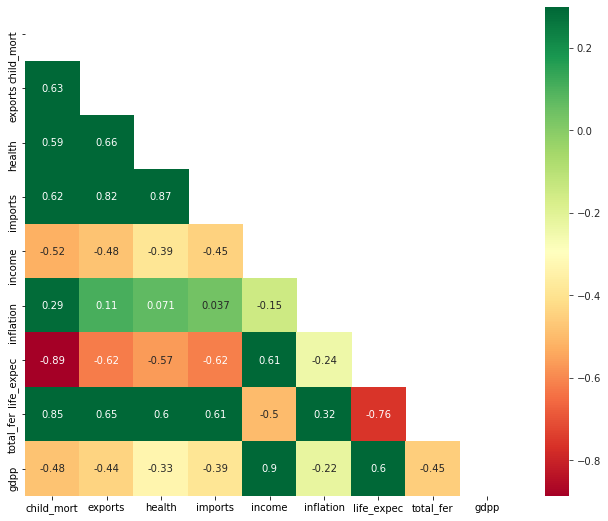

In [12]:
# correlation on Heatmap
mask = np.zeros_like(cor)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
with sns.axes_style("white"):
    ax = sns.heatmap(cor, mask=mask,vmax=.3, square=True,cmap='RdYlGn',annot=True);

### Inferences after doing univariate and bivariate analysis
- All the columns are following the normal distribution.
- exports and imports are following a linear trend.
- income and life expectancy increases as gdpp increase. Which is expected.
- life expectancy decreases with increase fertility and child mortality.

## Outlier Treatment

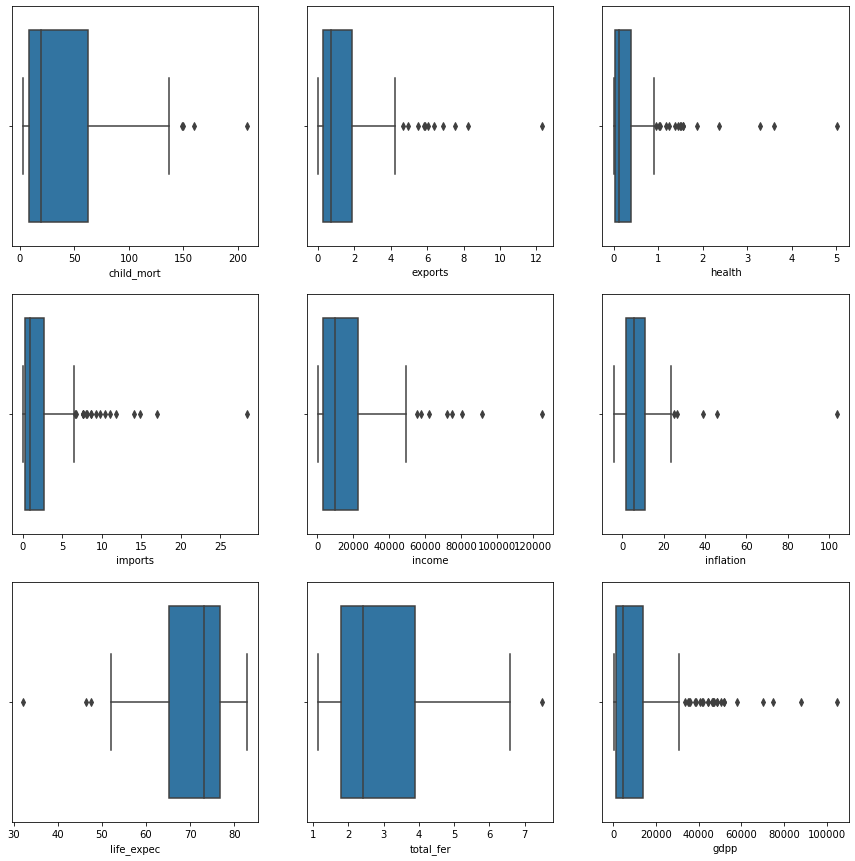

In [13]:
# ploting box plot for each numerical variable
col=cdata.columns[1:]
plt.figure(figsize = (15,15))
for i in enumerate(col):
    plt.subplot(3,3, i[0]+1)
    sns.boxplot(cdata[i[1]])

from above it can be seen that it would be benificial we cap the outliers rather than deleting the data which might hamper the data.

Since, lower range outlier of CHILD_MORT, INFLATION, TOTAL_FERTI would be of no use in this case study. We will cap lower range outlier for these columns and leave upper range outliers as is.

For all other columns, Upper range outliers would not be any use, So, we will cap upper range outliers for remaining and leave lower range outliers as is.

In [14]:
# Caping upper range outliers for cols except CHILD_MORT, INFLATION, TOTAL_FERTI
cdata.columns

Index(['country', 'child_mort', 'exports', 'health', 'imports', 'income',
       'inflation', 'life_expec', 'total_fer', 'gdpp'],
      dtype='object')

In [15]:
# capping upper range of below columns to 0.93 percentile as by doing this large range outlier will be handled 
#but all outliers would not be fully capped
ocols=cdata[['exports', 'health', 'imports', 'income', 'life_expec', 'gdpp']]
for i in ocols:
    q1=cdata[i].quantile(0.93)
    cdata[i][cdata[i]>=q1] = q1

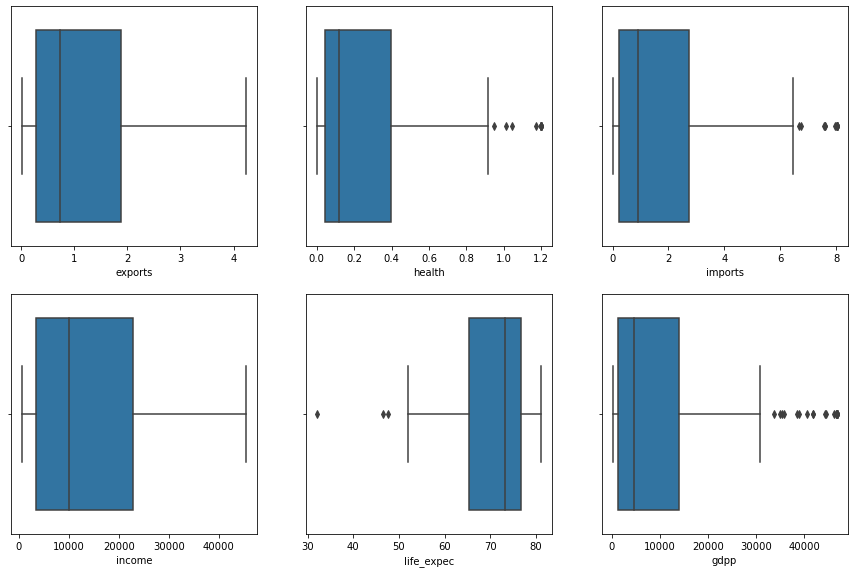

In [16]:
col1=cdata[['exports', 'health', 'imports', 'income', 'life_expec', 'gdpp']]
plt.figure(figsize = (15,15))
for i in enumerate(col1):
    plt.subplot(3,3, i[0]+1)
    sns.boxplot(cdata[i[1]])

Very high upper range outliers are handled. Lower range outlier not needed.

## Check the cluster tendancy: Hopkin's Test

In [17]:
#Calculating the Hopkins statistic
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [18]:
hopkins(cdata.drop('country', axis=1))

0.8830630934481913

In [19]:
#checking for 20 iterations if we are getting value closer to above number
for i in range(20):
    print(hopkins(cdata.drop('country', axis=1)),end=' | ')

0.833156675360394 | 0.8905892715180439 | 0.9552296253345077 | 0.9575563445354495 | 0.9321198164966299 | 0.9162303430528383 | 0.8724597366250282 | 0.8908271809901095 | 0.8637105881154279 | 0.9217499816059744 | 0.9436135146448462 | 0.9544438997084976 | 0.888959831980287 | 0.9224204609553608 | 0.8737351122219984 | 0.9410334308764726 | 0.9204016834317068 | 0.9013460260908023 | 0.9454599251290456 | 0.8917784119154407 | 

From above hopikin's number we can say that around 90% of data is different from the randomly scattered data. Which is good for clustering

## Scaling

In [20]:
ss = StandardScaler()
scaled_df = ss.fit_transform(cdata.drop("country",axis=1))
scaled_df

array([[ 1.29153238,  0.41032509,  2.56562201, ..., -1.62533148,
         1.90288227, -0.76373826],
       [-0.5389489 , -0.45449433, -0.3483403 , ...,  0.65877774,
        -0.85997281, -0.52527925],
       [-0.27283273, -0.3187441 , -0.53524356, ...,  0.68150519,
        -0.0384044 , -0.50033443],
       ...,
       [-0.37231541,  2.27309833,  0.66678824, ...,  0.29513846,
        -0.66120626, -0.71270251],
       [ 0.44841668,  0.78108748,  0.31143489, ..., -0.34123028,
         1.14094382, -0.71270251],
       [ 1.11495062,  0.9690016 ,  0.33388274, ..., -2.10260804,
         1.6246091 , -0.70258974]])

In [21]:
# mapping column names to scaled data
scaled_df = pd.DataFrame(scaled_df)
scaled_df.columns = cdata.columns[1:]
scaled_df.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.291532,0.410325,2.565622,2.355060,-0.970181,0.157336,-1.625331,1.902882,-0.763738
1,-0.538949,-0.454494,-0.348340,-0.345996,-0.392219,-0.312347,0.658778,-0.859973,-0.525279
2,-0.272833,-0.318744,-0.535244,-0.537771,-0.185904,0.789274,0.681505,-0.038404,-0.500334
3,2.007808,0.376889,-0.571030,-0.335290,-0.672170,1.387054,-1.182146,2.128151,-0.563034
4,-0.695634,-0.694338,-0.658833,-0.625395,0.244789,-0.601749,0.715596,-0.541946,0.021484


## Find the best value of k

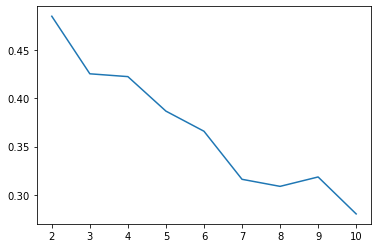

In [22]:
# plotting silhouette score for data
from sklearn.metrics import silhouette_score

sil = []

for k in range(2,11):
    kmean = KMeans(n_clusters = k, random_state = 0).fit(scaled_df)
    sil.append([k, silhouette_score(scaled_df, kmean.labels_)])

sil = pd.DataFrame(sil)

plt.plot(sil[0], sil[1])
plt.show()

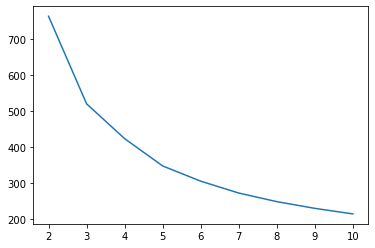

In [23]:
# plotting by ssd elbow curve
ssd = []
for k in range(2,11):
    kmean = KMeans(n_clusters = k).fit(scaled_df)
    ssd.append([k, kmean.inertia_])
    
ssd = pd.DataFrame(ssd)
plt.plot(ssd[0], ssd[1])
plt.show()

Elbow can be seen at k=3 or k=4. Going for k=3 first and see if clusters are coming fine

## Using the k=3 (at first), perform final KMeans Analysis

In [24]:
# kmeans for k=3
kmean = KMeans(n_clusters = 3, random_state = 0)
kmean.fit(scaled_df)

KMeans(n_clusters=3, random_state=0)

In [25]:
kmean.labels_

array([0, 1, 1, 0, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1,
       1, 2, 1, 0, 0, 0, 0, 2, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 2, 2,
       2, 1, 1, 1, 1, 1, 0, 1, 1, 2, 2, 1, 0, 1, 2, 0, 2, 1, 1, 0, 0, 1,
       0, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 0, 0, 2, 0, 0, 1, 1, 0,
       0, 1, 1, 2, 1, 0, 0, 1, 1, 0, 2, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       2, 2, 0, 0, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 0, 1, 2, 0, 1, 1,
       0, 2, 1, 2, 0, 1, 2, 2, 1, 1, 0, 1, 2, 2, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 2, 2, 2, 1, 1, 1, 1, 0, 0, 0])

In [26]:
# mapping labels to dataset 
df1=cdata.copy()
df1["cid_k3"] = kmean.labels_
df1.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cid_k3
0,Afghanistan,90.2,1.808318,1.199254,8.008388,1610,9.44,56.2,5.82,553,0
1,Albania,16.6,0.684597,0.160147,1.188264,9930,4.49,76.3,1.65,4090,1
2,Algeria,27.3,0.860987,0.093498,0.704036,12900,16.10,76.5,2.89,4460,1
3,Angola,119.0,1.764873,0.080737,1.215297,5900,22.40,60.1,6.16,3530,0
4,Antigua and Barbuda,10.3,0.372951,0.049426,0.482787,19100,1.44,76.8,2.13,12200,1


In [27]:
# Let's check how may data points we have in each cluster
df1.cid_k3.value_counts()

1    84
0    45
2    38
Name: cid_k3, dtype: int64

### Visualize the cluster using scatter plots

Plot for: 
- GDPP
- Income
- Child_Mort

Choosing this because there significance distplots look more promising for clutering

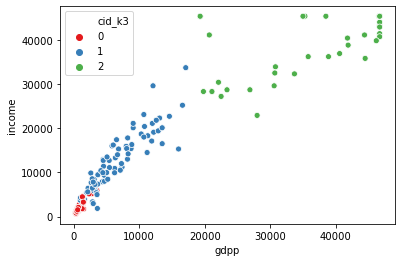

In [28]:
# mapping profiling variables to each other
# gdpp vs income
sns.scatterplot(x ='gdpp', y ='income', hue = 'cid_k3', data =df1, palette = 'Set1')
plt.show()

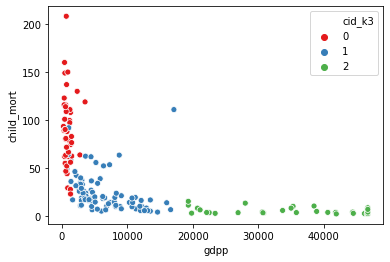

In [29]:
# mapping profiling variables to each other
# gdpp vs child_mort
sns.scatterplot(x ='gdpp', y ='child_mort', hue = 'cid_k3', data =df1, palette = 'Set1')
plt.show()

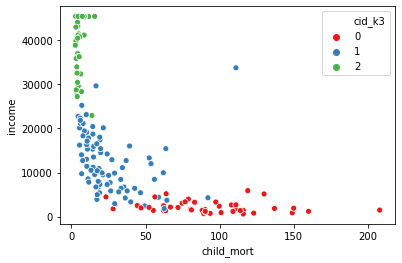

In [30]:
# mapping profiling variables to each other
# child_mort vs income
sns.scatterplot(x ='child_mort', y ='income', hue = 'cid_k3', data =df1, palette = 'Set1')
plt.show()

It can be seen from above graphes that we have 3 clusters for all the columns we took. There are some mergings in some, but we are good with this as clusters are clear.

## Cluster Profiling for k=3:

find one such cluster that is having LOW GDPP, LOW INCOME and HIGH CHILD_MORT.

In [31]:
# means of required column
df1[['gdpp','income','child_mort','cid_k3']].groupby("cid_k3").mean()

,gdpp,income,child_mort
cid_k3,,,
0,936.400000,2206.288889,90.344444
1,6465.190476,12277.142857,25.135714
2,36814.947368,38701.473684,5.636842


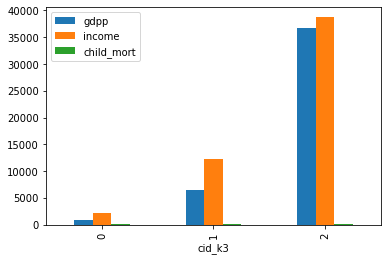

In [32]:
df1[['gdpp','income','child_mort','cid_k3']].groupby("cid_k3").mean().plot(kind='bar')
plt.show()

From Above graph of cluster profiling, following inferences can be drawn:
- Cluster 0 : lowest GDPP, Lowest income, Highest child_mort (can be seen from average as well). Countries in this cluster are in dire need of aid and less developed.

- Cluster 1 : low GDP, income and high child_mort Thus, they may need treatment.

- cluster 2 : highest income, GDP and lowest child_mort indicating these countries are developed and does not need aid.

In [33]:
c1 = df1[df1['cid_k3']==0]
c1.head(10)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cid_k3
0,Afghanistan,90.2,1.808318,1.199254,8.008388,1610,9.440,56.2,5.82,553,0
3,Angola,119.0,1.764873,0.080737,1.215297,5900,22.400,60.1,6.16,3530,0
17,Benin,111.0,3.139842,0.540897,4.907652,1820,0.885,61.8,5.36,758,0
25,Burkina Faso,116.0,3.339130,1.172174,5.147826,1430,6.810,57.9,5.87,575,0
26,Burundi,93.6,3.861472,1.199254,8.008388,764,12.300,57.7,6.26,231,0
27,Cambodia,44.4,4.228753,0.722646,7.569975,2520,3.120,66.1,2.88,786,0
28,Cameroon,108.0,1.694656,0.391603,2.061069,2660,1.910,57.3,5.11,1310,0
31,Central African Republic,149.0,2.645740,0.892377,5.941704,888,2.010,47.5,5.21,446,0
32,Chad,150.0,4.102564,0.505017,4.849498,1930,6.390,56.5,6.59,897,0
36,Comoros,88.2,2.145644,0.586476,6.723017,1410,3.870,65.9,4.75,769,0


In [34]:
c1.sort_values(by = ['gdpp', 'child_mort', 'income'], ascending = [True, False, True]).head(10)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cid_k3
26,Burundi,93.6,3.861472,1.199254,8.008388,764,12.30,57.7,6.26,231,0
88,Liberia,89.3,4.228753,1.199254,8.008388,700,5.47,60.8,5.02,327,0
37,"Congo, Dem. Rep.",116.0,4.228753,1.199254,8.008388,609,20.80,57.5,6.54,334,0
112,Niger,123.0,4.228753,1.199254,8.008388,814,2.55,58.8,7.49,348,0
132,Sierra Leone,160.0,4.210526,1.199254,8.008388,1220,17.20,55.0,5.20,399,0
93,Madagascar,62.2,4.228753,0.912833,8.008388,1390,8.79,60.8,4.60,413,0
106,Mozambique,101.0,4.228753,1.199254,8.008388,918,7.64,54.5,5.56,419,0
31,Central African Republic,149.0,2.645740,0.892377,5.941704,888,2.01,47.5,5.21,446,0
94,Malawi,90.5,4.228753,1.199254,7.603486,1030,12.10,53.1,5.31,459,0
50,Eritrea,55.2,0.993776,0.551867,4.834025,1420,11.60,61.7,4.61,482,0


# for more precision we can try for k=4 and see if we can cut out some more countries

In [35]:
# kmeans for k=4
kmean = KMeans(n_clusters = 4, random_state = 0)
kmean.fit(scaled_df)
kmean.labels_

array([1, 0, 0, 3, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0,
       0, 2, 0, 1, 1, 1, 3, 2, 0, 1, 1, 0, 0, 0, 1, 1, 3, 0, 1, 0, 2, 2,
       2, 0, 0, 0, 0, 3, 3, 0, 0, 2, 2, 3, 1, 0, 2, 3, 2, 0, 0, 1, 1, 0,
       1, 0, 2, 0, 0, 0, 3, 2, 2, 2, 0, 2, 0, 0, 1, 1, 2, 1, 1, 0, 0, 1,
       1, 0, 0, 2, 0, 1, 1, 0, 0, 1, 2, 1, 0, 0, 0, 3, 0, 0, 1, 0, 0, 1,
       2, 2, 1, 3, 2, 2, 3, 0, 0, 0, 0, 0, 2, 2, 0, 0, 1, 0, 2, 1, 0, 0,
       1, 2, 0, 2, 1, 0, 2, 2, 0, 0, 3, 0, 2, 2, 1, 1, 0, 3, 1, 0, 0, 0,
       0, 1, 0, 2, 2, 2, 0, 0, 0, 3, 1, 3, 3])

In [36]:
# mapping labels to dataset 
df1["cid_k4"] = kmean.labels_
df1.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cid_k3,cid_k4
0,Afghanistan,90.2,1.808318,1.199254,8.008388,1610,9.44,56.2,5.82,553,0,1
1,Albania,16.6,0.684597,0.160147,1.188264,9930,4.49,76.3,1.65,4090,1,0
2,Algeria,27.3,0.860987,0.093498,0.704036,12900,16.10,76.5,2.89,4460,1,0
3,Angola,119.0,1.764873,0.080737,1.215297,5900,22.40,60.1,6.16,3530,0,3
4,Antigua and Barbuda,10.3,0.372951,0.049426,0.482787,19100,1.44,76.8,2.13,12200,1,0


In [37]:
# Let's check how may data points we have in each cluster
df1.cid_k4.value_counts()

0    77
2    38
1    36
3    16
Name: cid_k4, dtype: int64

### Visualising the clusters with k-4

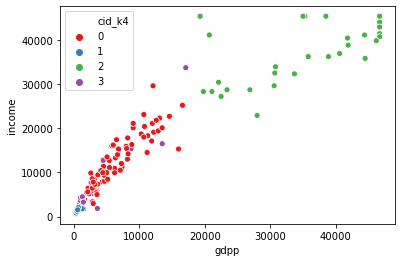

In [38]:
# gdpp vs income
sns.scatterplot(x ='gdpp', y ='income', hue = 'cid_k4', data =df1, palette = 'Set1')
plt.show()

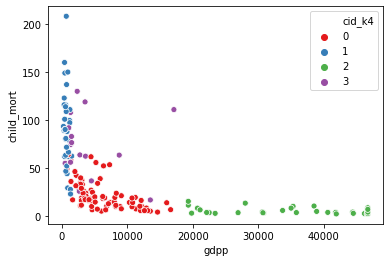

In [39]:
# gdpp vs child_mort
sns.scatterplot(x ='gdpp', y ='child_mort', hue = 'cid_k4', data =df1, palette = 'Set1')
plt.show()

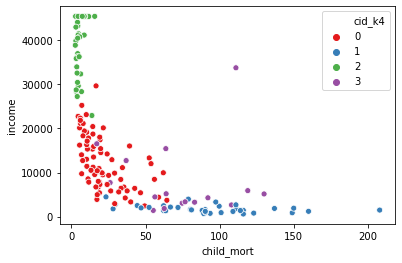

In [40]:
# child_mort vs income
sns.scatterplot(x ='child_mort', y ='income', hue = 'cid_k4', data =df1, palette = 'Set1')
plt.show()

### Cluster Profiling for k=4:

In [41]:
# means of required column
df1[['gdpp','income','child_mort','cid_k4']].groupby("cid_k4").mean()

,gdpp,income,child_mort
cid_k4,,,
0,6388.779221,12196.623377,22.102597
1,727.388889,1799.250000,91.627778
2,36814.947368,38701.473684,5.636842
3,4193.250000,7915.625000,73.525000


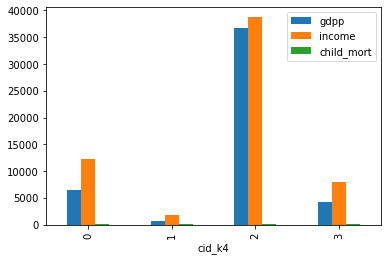

In [42]:
df1[['gdpp','income','child_mort','cid_k4']].groupby("cid_k4").mean().plot(kind='bar')
plt.show()

From Above graph of cluster profiling, following inferences can be drawn:

Cluster 0 : low GDPP, Low income, High child_mort. But doesn't seem a good cluster, since it may need treatment.

Cluster 1 : lowest GDP, income and highest child_mort. Seems like a good cluster to go with, they are in dire need of the aid.

cluster 2 : highest income, GDP and lowest child_mort indicating these countries are developed and does not need aid.

cluster 3 : low GDPP, Low income, High child_mort. But doesn't seem a good cluster, since it may need treatment.

In [43]:
c2 = df1[df1['cid_k4']==1]
c2.head(10)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cid_k3,cid_k4
0,Afghanistan,90.2,1.808318,1.199254,8.008388,1610,9.440,56.2,5.82,553,0,1
17,Benin,111.0,3.139842,0.540897,4.907652,1820,0.885,61.8,5.36,758,0,1
25,Burkina Faso,116.0,3.339130,1.172174,5.147826,1430,6.810,57.9,5.87,575,0,1
26,Burundi,93.6,3.861472,1.199254,8.008388,764,12.300,57.7,6.26,231,0,1
27,Cambodia,44.4,4.228753,0.722646,7.569975,2520,3.120,66.1,2.88,786,0,1
31,Central African Republic,149.0,2.645740,0.892377,5.941704,888,2.010,47.5,5.21,446,0,1
32,Chad,150.0,4.102564,0.505017,4.849498,1930,6.390,56.5,6.59,897,0,1
36,Comoros,88.2,2.145644,0.586476,6.723017,1410,3.870,65.9,4.75,769,0,1
37,"Congo, Dem. Rep.",116.0,4.228753,1.199254,8.008388,609,20.800,57.5,6.54,334,0,1
40,Cote d'Ivoire,111.0,4.147541,0.434426,3.549180,2690,5.390,56.3,5.27,1220,0,1


In [44]:
c2.sort_values(by = ['gdpp', 'child_mort', 'income'], ascending = [True, False, True]).head(10)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cid_k3,cid_k4
26,Burundi,93.6,3.861472,1.199254,8.008388,764,12.30,57.7,6.26,231,0,1
88,Liberia,89.3,4.228753,1.199254,8.008388,700,5.47,60.8,5.02,327,0,1
37,"Congo, Dem. Rep.",116.0,4.228753,1.199254,8.008388,609,20.80,57.5,6.54,334,0,1
112,Niger,123.0,4.228753,1.199254,8.008388,814,2.55,58.8,7.49,348,0,1
132,Sierra Leone,160.0,4.210526,1.199254,8.008388,1220,17.20,55.0,5.20,399,0,1
93,Madagascar,62.2,4.228753,0.912833,8.008388,1390,8.79,60.8,4.60,413,0,1
106,Mozambique,101.0,4.228753,1.199254,8.008388,918,7.64,54.5,5.56,419,0,1
31,Central African Republic,149.0,2.645740,0.892377,5.941704,888,2.01,47.5,5.21,446,0,1
94,Malawi,90.5,4.228753,1.199254,7.603486,1030,12.10,53.1,5.31,459,0,1
150,Togo,90.3,4.228753,1.199254,8.008388,1210,1.18,58.7,4.87,488,0,1


# Hierarchial Clustering

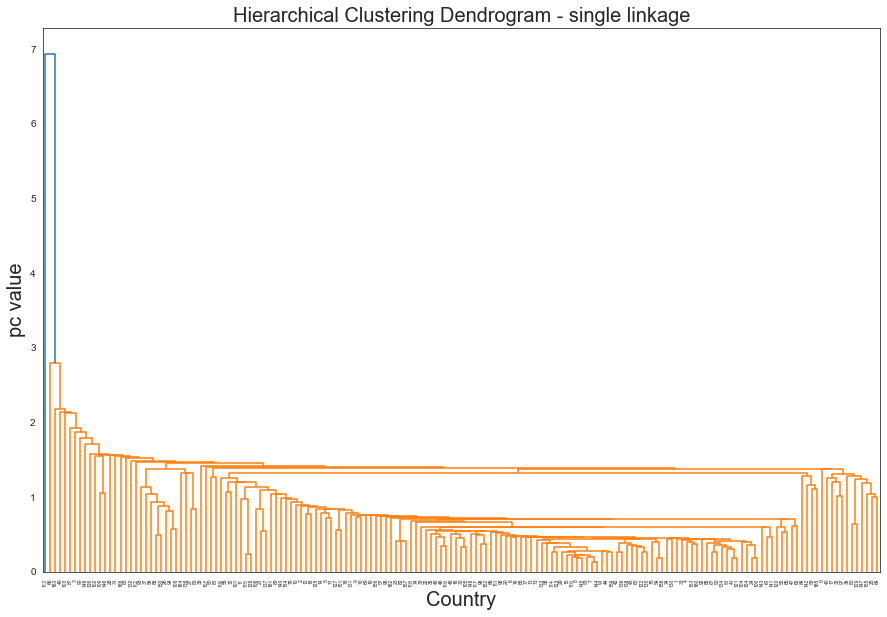

In [45]:
# single linkage


plt.figure(figsize=(15,10))
sns.set_style('white')

# setting the labels on axes and title

plt.title('Hierarchical Clustering Dendrogram - single linkage',fontsize=20)
plt.xlabel('Country',fontsize=20)
plt.ylabel('pc value',fontsize=20)

mergings = linkage(scaled_df, method="single", metric='euclidean')
dendrogram(mergings)
plt.show() 

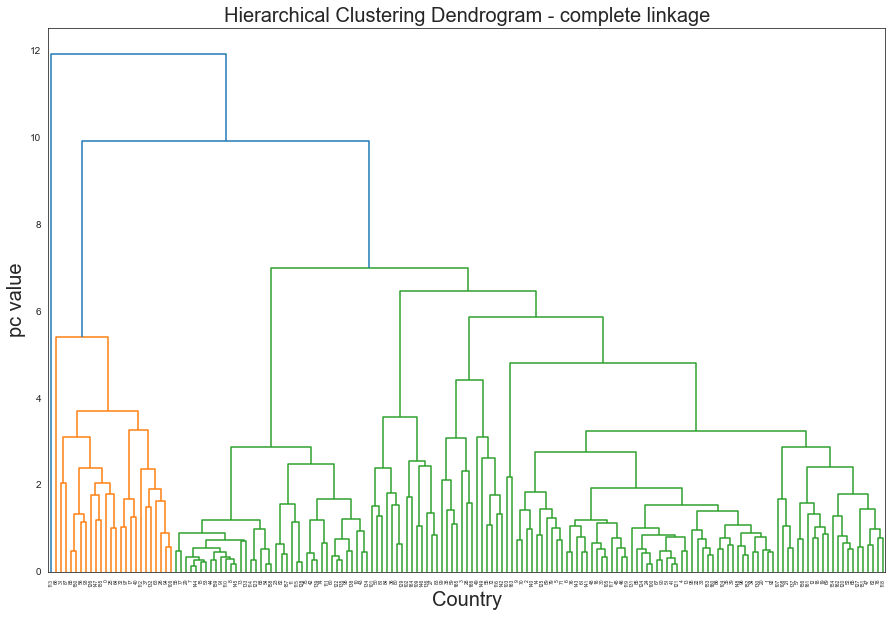

In [46]:
# complete linkage
plt.figure(figsize=(15,10))
sns.set_style('white')

# setting the labels on axes and title

plt.title('Hierarchical Clustering Dendrogram - complete linkage',fontsize=20)
plt.xlabel('Country',fontsize=20)
plt.ylabel('pc value',fontsize=20)

complete_d = linkage(scaled_df,method='complete', metric='euclidean')
dendrogram(complete_d)
plt.show()

In [47]:
# 3 clusters
cluster_labels = cut_tree(complete_d,n_clusters=3).reshape(-1,)
cluster_labels

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [48]:
# assign cluster labels
df1['clabels_h3'] = cluster_labels
df1.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cid_k3,cid_k4,clabels_h3
0,Afghanistan,90.2,1.808318,1.199254,8.008388,1610,9.44,56.2,5.82,553,0,1,0
1,Albania,16.6,0.684597,0.160147,1.188264,9930,4.49,76.3,1.65,4090,1,0,1
2,Algeria,27.3,0.860987,0.093498,0.704036,12900,16.10,76.5,2.89,4460,1,0,1
3,Angola,119.0,1.764873,0.080737,1.215297,5900,22.40,60.1,6.16,3530,0,3,1
4,Antigua and Barbuda,10.3,0.372951,0.049426,0.482787,19100,1.44,76.8,2.13,12200,1,0,1


#### Visualise clusters

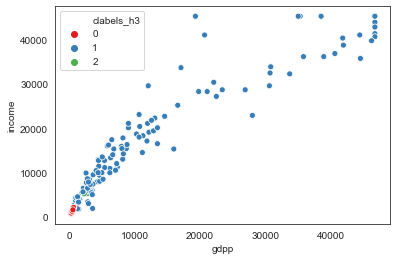

In [49]:
# gdpp vs income
sns.scatterplot(x ='gdpp', y ='income', hue = 'clabels_h3', data =df1, palette = 'Set1')
plt.show()

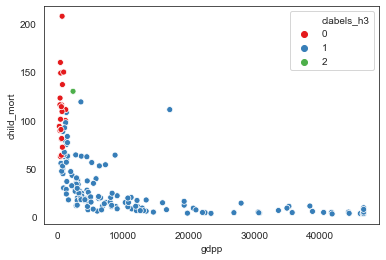

In [50]:
# gdpp vs child_mort
sns.scatterplot(x ='gdpp', y ='child_mort', hue = 'clabels_h3', data =df1, palette = 'Set1')
plt.show()

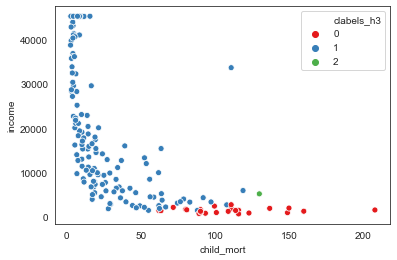

In [51]:
# child_mort vs income
sns.scatterplot(x ='child_mort', y ='income', hue = 'clabels_h3', data =df1, palette = 'Set1')
plt.show()

We can see that from above graphs that 2nd cluster is not that significant, While in K means Clusters were significant

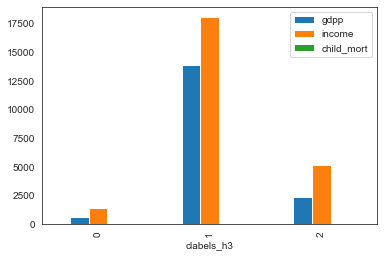

In [52]:
# plotting clusters for required columns
df1[['gdpp','income','child_mort','clabels_h3']].groupby("clabels_h3").mean().plot(kind='bar')
plt.show()

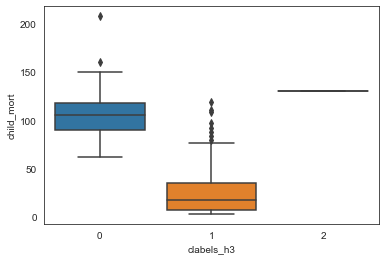

In [53]:
# plots
# child_mort
sns.boxplot(x='clabels_h3', y='child_mort', data=df1)
plt.show()

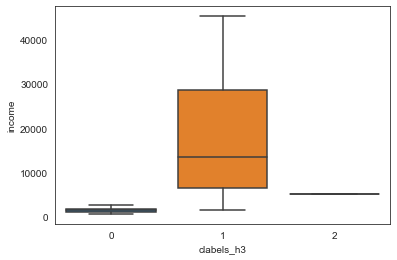

In [54]:
# income
sns.boxplot(x='clabels_h3', y='income', data=df1)
plt.show()

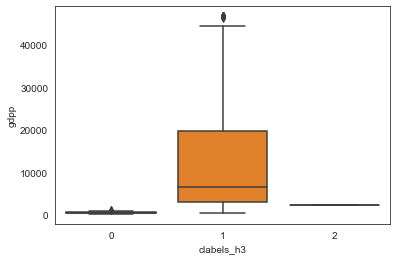

In [55]:
# gdpp
sns.boxplot(x='clabels_h3', y='gdpp', data=df1)
plt.show()

In [56]:
# checking values for cluster 0 to according to condition
c3 = df1[df1['clabels_h3']==0]
c3.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cid_k3,cid_k4,clabels_h3
0,Afghanistan,90.2,1.808318,1.199254,8.008388,1610,9.440,56.2,5.82,553,0,1,0
17,Benin,111.0,3.139842,0.540897,4.907652,1820,0.885,61.8,5.36,758,0,1,0
25,Burkina Faso,116.0,3.339130,1.172174,5.147826,1430,6.810,57.9,5.87,575,0,1,0
26,Burundi,93.6,3.861472,1.199254,8.008388,764,12.300,57.7,6.26,231,0,1,0
31,Central African Republic,149.0,2.645740,0.892377,5.941704,888,2.010,47.5,5.21,446,0,1,0


From above box plots, we can say for sure that cluster 0 is the one we will be further working on

# finding clusters for which we have LOW GDPP, LOW INCOME and HIGH CHILD_MORT from all the 3 cluster ids i.e hierarchical clustering, kmeans=3 clustering, kmeans=4 clustering

In [57]:
# By hierarchial 
h_cluster = c3.sort_values(by = ['gdpp', 'child_mort', 'income'], ascending = [True, False, True]).head(10)
h_cluster

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cid_k3,cid_k4,clabels_h3
26,Burundi,93.6,3.861472,1.199254,8.008388,764,12.30,57.7,6.26,231,0,1,0
88,Liberia,89.3,4.228753,1.199254,8.008388,700,5.47,60.8,5.02,327,0,1,0
37,"Congo, Dem. Rep.",116.0,4.228753,1.199254,8.008388,609,20.80,57.5,6.54,334,0,1,0
112,Niger,123.0,4.228753,1.199254,8.008388,814,2.55,58.8,7.49,348,0,1,0
132,Sierra Leone,160.0,4.210526,1.199254,8.008388,1220,17.20,55.0,5.20,399,0,1,0
93,Madagascar,62.2,4.228753,0.912833,8.008388,1390,8.79,60.8,4.60,413,0,1,0
106,Mozambique,101.0,4.228753,1.199254,8.008388,918,7.64,54.5,5.56,419,0,1,0
31,Central African Republic,149.0,2.645740,0.892377,5.941704,888,2.01,47.5,5.21,446,0,1,0
94,Malawi,90.5,4.228753,1.199254,7.603486,1030,12.10,53.1,5.31,459,0,1,0
150,Togo,90.3,4.228753,1.199254,8.008388,1210,1.18,58.7,4.87,488,0,1,0


In [58]:
# By K means k==3
k3_cluster= c1.sort_values(by = ['gdpp', 'child_mort', 'income'], ascending = [True, False, True]).head(10)
k3_cluster

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cid_k3
26,Burundi,93.6,3.861472,1.199254,8.008388,764,12.30,57.7,6.26,231,0
88,Liberia,89.3,4.228753,1.199254,8.008388,700,5.47,60.8,5.02,327,0
37,"Congo, Dem. Rep.",116.0,4.228753,1.199254,8.008388,609,20.80,57.5,6.54,334,0
112,Niger,123.0,4.228753,1.199254,8.008388,814,2.55,58.8,7.49,348,0
132,Sierra Leone,160.0,4.210526,1.199254,8.008388,1220,17.20,55.0,5.20,399,0
93,Madagascar,62.2,4.228753,0.912833,8.008388,1390,8.79,60.8,4.60,413,0
106,Mozambique,101.0,4.228753,1.199254,8.008388,918,7.64,54.5,5.56,419,0
31,Central African Republic,149.0,2.645740,0.892377,5.941704,888,2.01,47.5,5.21,446,0
94,Malawi,90.5,4.228753,1.199254,7.603486,1030,12.10,53.1,5.31,459,0
50,Eritrea,55.2,0.993776,0.551867,4.834025,1420,11.60,61.7,4.61,482,0


In [59]:
# By K means k==4
k4_cluster= c2.sort_values(by = ['gdpp', 'child_mort', 'income'], ascending = [True, False, True]).head(10)
k4_cluster

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cid_k3,cid_k4
26,Burundi,93.6,3.861472,1.199254,8.008388,764,12.30,57.7,6.26,231,0,1
88,Liberia,89.3,4.228753,1.199254,8.008388,700,5.47,60.8,5.02,327,0,1
37,"Congo, Dem. Rep.",116.0,4.228753,1.199254,8.008388,609,20.80,57.5,6.54,334,0,1
112,Niger,123.0,4.228753,1.199254,8.008388,814,2.55,58.8,7.49,348,0,1
132,Sierra Leone,160.0,4.210526,1.199254,8.008388,1220,17.20,55.0,5.20,399,0,1
93,Madagascar,62.2,4.228753,0.912833,8.008388,1390,8.79,60.8,4.60,413,0,1
106,Mozambique,101.0,4.228753,1.199254,8.008388,918,7.64,54.5,5.56,419,0,1
31,Central African Republic,149.0,2.645740,0.892377,5.941704,888,2.01,47.5,5.21,446,0,1
94,Malawi,90.5,4.228753,1.199254,7.603486,1030,12.10,53.1,5.31,459,0,1
150,Togo,90.3,4.228753,1.199254,8.008388,1210,1.18,58.7,4.87,488,0,1


In [60]:
# top 10 countries by hierarichal clustering
h_cluster.country

26                      Burundi
88                      Liberia
37             Congo, Dem. Rep.
112                       Niger
132                Sierra Leone
93                   Madagascar
106                  Mozambique
31     Central African Republic
94                       Malawi
150                        Togo
Name: country, dtype: object

In [61]:
# top 10 countries by K means =3
k3_cluster.country

26                      Burundi
88                      Liberia
37             Congo, Dem. Rep.
112                       Niger
132                Sierra Leone
93                   Madagascar
106                  Mozambique
31     Central African Republic
94                       Malawi
50                      Eritrea
Name: country, dtype: object

In [62]:
# top 10 countries by k =4
k4_cluster.country

26                      Burundi
88                      Liberia
37             Congo, Dem. Rep.
112                       Niger
132                Sierra Leone
93                   Madagascar
106                  Mozambique
31     Central African Republic
94                       Malawi
150                        Togo
Name: country, dtype: object

# Conclusions:

## From above, we found out the top 10 countries for each Clustering method that we applied.

### Countries which need aid are :
### -  Burundi
### - Liberia
### - Congo, Dem. Rep.
### - Niger
### - Sierra Leone
### - Madagascar
### - Mozambique
### - Central African Republic
### - Malawi
### - Togo
### - Eritrea